In [1]:
from jax3dp3.dino import Dino
import jax3dp3 as j
import os
import torch
import numpy as np
import matplotlib
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import torchvision.transforms as T


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dinov2_vitg14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14')
dino = dinov2_vitg14.to(device)  # Same issue with larger model


feat_dim = 1536 # vitg14

def get_features(rgbd):
    img = j.get_rgb_image(rgbd.rgb).convert('RGB')
    patch_h, patch_w = np.array(img.size) // 14
    transform = T.Compose([
        T.GaussianBlur(9, sigma=(0.1, 2.0)),
        T.Resize((patch_h * 14, patch_w * 14)),
        T.CenterCrop((patch_h * 14, patch_w * 14)),
        T.ToTensor(),
        T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])
    tensor = transform(img)[:3].unsqueeze(0).to(device)
    with torch.no_grad():
        features_dict = dinov2_vitg14.forward_features(tensor)
        features = features_dict['x_norm_patchtokens'][0].reshape((patch_h, patch_w, feat_dim)).permute(2, 0, 1).unsqueeze(0)
    print(features.shape)
    features = torch.nn.functional.interpolate(
        features, [img.height, img.width], mode="bilinear", align_corners=True
    )
    img_feat_norm = torch.nn.functional.normalize(features, dim=1)
    return jnp.array(img_feat_norm.cpu().detach().numpy())[0]


Using cache found in /home/nishadgothoskar/.cache/torch/hub/facebookresearch_dinov2_main


In [11]:
bop_ycb_dir = os.path.join(j.utils.get_assets_dir(), "bop/ycbv")
rgbd, gt_ids, gt_poses, masks = j.ycb_loader.get_test_img('53', '1', bop_ycb_dir)

embeddings = get_features(rgbd)

rgbd2, gt_ids2, gt_poses2, masks2 = j.ycb_loader.get_test_img('50', '620', bop_ycb_dir)
# rgbd2, gt_ids2, gt_poses2, masks2 = j.ycb_loader.get_test_img('56', '1', bop_ycb_dir)
embeddings2 = get_features(rgbd2)

torch.Size([1, 1536, 45, 34])
torch.Size([1, 1536, 45, 34])


0.45733768 1.0
0.46250477 0.78155005


/tmp/ipykernel_1163367/2286262492.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap("jet")


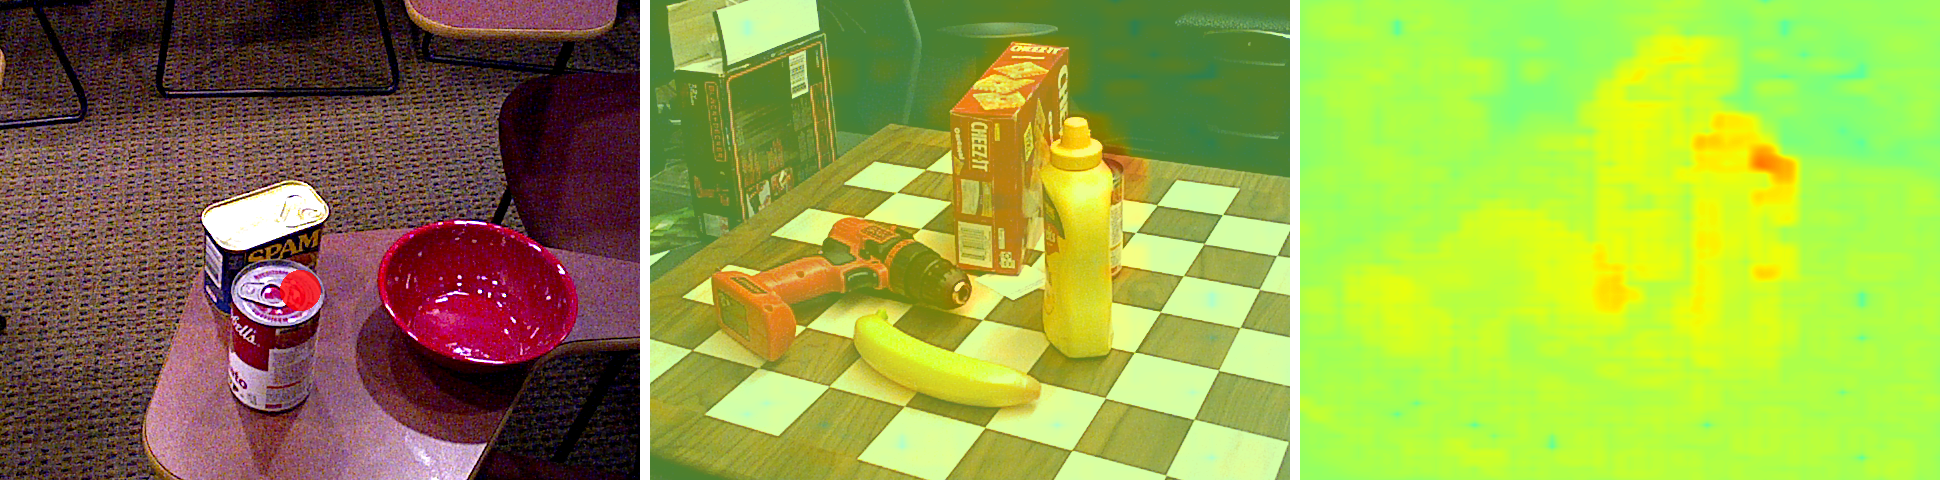

In [12]:

clickx, clicky = 300, 290
selected_embedding = embeddings[:, clicky, clickx]  # (512,)


similarity_rel1 = get_similarity(selected_embedding, embeddings)
similarity_rel2 = get_similarity(selected_embedding, embeddings2)

cmap = matplotlib.cm.get_cmap("jet")
similarity_colormap1 = j.get_rgb_image(cmap(similarity_rel1)[..., :3] * 255.0)
similarity_colormap2 = j.get_rgb_image(cmap(similarity_rel2)[..., :3] * 255.0)

rgb1 = j.get_rgb_image(rgbd.rgb)
overlay = Image.new('RGBA', rgb1.size)
draw = ImageDraw.Draw(overlay)
draw.ellipse([clickx-20, clicky-20, clickx+20, clicky+20],fill=(255, 0, 0, 200))
rgb1.paste(overlay, (0,0), overlay)

rgb2 = j.get_rgb_image(rgbd2.rgb)

j.hstack_images(
    [
        rgb1,
        j.overlay_image(rgb2, similarity_colormap2),
        similarity_colormap2
    ]
)

In [ ]:
embeddings.shape

In [ ]:
object_index = 0
mask = masks[object_index]
object_embeddings = embeddings[:, mask]
print(object_embeddings.shape)
j.get_depth_image(1.0 * mask)

In [ ]:
subset = jax.random.choice(jax.random.PRNGKey(10), object_embeddings.shape[0], shape=(1000,))
object_embeddings_subset = object_embeddings[:, subset]

In [ ]:
print(embeddings.shape)
print(object_embeddings_subset.shape)

In [ ]:
similarity = jnp.einsum("iab, ic->abc", embeddings, object_embeddings_subset)

In [ ]:
similarity.shape

In [ ]:
j.get_depth_image(similarity.max(-1), min=-1.0, max=1.0)

In [ ]:
similarity = jnp.einsum("iab, ic->abc", embeddings2, object_embeddings_subset)

In [ ]:
j.get_depth_image(similarity.max(-1), min=-1.0, max=1.0)

In [59]:
similarity.min()

Array(-0.10357141, dtype=float32)

In [8]:
def get_similarity( selected_embedding, embeddings, similarity_thresh=0.1):
    similarity = ((selected_embedding.reshape(1,-1,1,1) * embeddings).sum(1) + 1.0) / 2.0
    print(similarity.min(),similarity.max())
    return similarity[0]
    similarity_thresh = 0.1
    similarity_rel = (similarity - similarity.min()) / (
        similarity.max() - similarity.min() + 1e-12
    )
    similarity_rel = similarity_rel[0]  # 1, H // 2, W // 2 -> # H // 2, W // 2
    similarity_rel[similarity_rel < similarity_thresh] = 0.0
    return similarity_rel

In [47]:
object_embeddings_subset.shape

(1000, 1536)